In [93]:
# EDA.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

GAMES_CSV = "games_march2025_cleaned.csv"
OUT_DIR = "analysis_output"
os.makedirs(OUT_DIR, exist_ok=True)

print("Loading data...")
games = pd.read_csv(GAMES_CSV)

# Inspect common column names: adjust if your files use different names

print("Games columns:", games.columns.tolist())





Loading data...
Games columns: ['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count', 'detailed_description', 'about_the_game', 'short_description', 'reviews', 'header_image', 'website', 'support_url', 'support_email', 'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url', 'achievements', 'recommendations', 'notes', 'supported_languages', 'full_audio_languages', 'packages', 'developers', 'publishers', 'categories', 'genres', 'screenshots', 'movies', 'user_score', 'score_rank', 'positive', 'negative', 'estimated_owners', 'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks', 'discount', 'peak_ccu', 'tags', 'pct_pos_total', 'num_reviews_total', 'pct_pos_recent', 'num_reviews_recent']


In [94]:
#  Detect multiplayer and singleplayer games by using the categories and tags columns.
mp_keywords = ["multiplayer", "co-op", "online", "pvp", "mmo"]

def is_multiplayer(text):
    text = str(text).lower()
    return any(k in text for k in mp_keywords)

games["is_multiplayer"] = games["categories"].apply(is_multiplayer) | games["tags"].apply(is_multiplayer)
games["is_singleplayer"] = games["categories"].str.contains("single-player", case=False, na=False)

We create binary flags identifying whether games have multiplayer or singleplayer features based on keywords in categories and tags.

In [95]:
# -------------------------------
# Step 2: Create 3 exclusive game groups: singleplayer, multiplayer, hybrid
# -------------------------------
games["game_type"] = "other"  # default

games.loc[games["is_singleplayer"] & ~games["is_multiplayer"], "game_type"] = "singleplayer"
games.loc[games["is_multiplayer"] & ~games["is_singleplayer"], "game_type"] = "multiplayer"
games.loc[games["is_multiplayer"] & games["is_singleplayer"], "game_type"] = "hybrid"

# Check distribution
print(games["game_type"].value_counts())

game_type
singleplayer    69491
hybrid          14908
multiplayer      3639
other            1580
Name: count, dtype: int64


In [96]:
# ----------------------------
# Step 3. Clean numeric columns
# ----------------------------
# Define numeric columns we'll use 
num_cols = {
    "metacritic_score": "metacritic_score",
    "user_score": "user_score",
    "positive": "positive",
    "negative": "negative",
    "num_reviews_total": "num_reviews_total",
    "pct_pos_total": "pct_pos_total",
    "price": "price",
    "average_playtime_forever": "average_playtime_forever",
    "peak_ccu": "peak_ccu"
}


In [97]:

# convert to numeric safely
for col in set(num_cols.values()):
    if col in games.columns:
        games[col] = pd.to_numeric(games[col], errors="coerce")
    else:
        games[col] = np.nan

# Treat 0 as missing for metacritic and user_score since that's how missing is encoded
games.loc[games["metacritic_score"] == 0, "metacritic_score"] = np.nan
games.loc[games["user_score"] == 0, "user_score"] = np.nan



In [98]:
# If positive/negative are missing but num_reviews_total exists, try to infer:
if games["positive"].isna().all() and "num_reviews_total" in games.columns:
    # assume pct_pos_total exists as fraction (0-1) or percent (0-100)
    if "pct_pos_total" in games.columns and not games["pct_pos_total"].isna().all():
        # detect scale: if max > 1 assume percent
        if games["pct_pos_total"].max(skipna=True) > 1:
            pct = games["pct_pos_total"] / 100.0
        else:
            pct = games["pct_pos_total"].fillna(0)
        games["positive"] = (pct * games["num_reviews_total"]).round()
        games["negative"] = (games["num_reviews_total"] - games["positive"]).clip(lower=0)
    else:
        # fallback: fill zeros
        games["positive"] = games["positive"].fillna(0)
        games["negative"] = games["negative"].fillna(0)
else:
    games["positive"] = games["positive"].fillna(0)
    games["negative"] = games["negative"].fillna(0)

# Ensure total_reviews (fallback)
games["total_reviews"] = games.get("num_reviews_total",
                                  games["positive"] + games["negative"]).fillna(0)

# ----------------------------
# Step 4. Create estimated owners, key metrics and the success index
# ----------------------------
# Use multiplier 30 as discussed: estimated_owners_est = total_reviews * 30
MULTIPLIER = 30
games["est_owners_est"] = games["total_reviews"] * MULTIPLIER

# review positivity (fraction 0-1). Avoid division by zero
games["review_score"] = games["positive"] / (games["positive"] + games["negative"])
games.loc[((games["positive"] + games["negative"]) == 0), "review_score"] = np.nan

# log owners for scaling
games["log_owners"] = np.where(
       games["est_owners_est"] > 0,
       np.log1p(games["est_owners_est"]),
       np.nan
   )

# success index: quality (review_score) * scale (log_owners)
# This places more weight on well-reviewed games with more buyers.
games["success_index"] = np.where(
       games["review_score"].notna() & games["log_owners"].notna(),
       games["review_score"] * games["log_owners"],
       np.nan
   )


/Users/tunaaslantay/Desktop/DSA_project/.venv/lib/python3.14/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/kq/dfsvyxmd3m3gjmgqx5c43hmc0000gn/T/ipykernel_4769/3027493825.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=["Singleplayer","Multiplayer","Hybrid"])


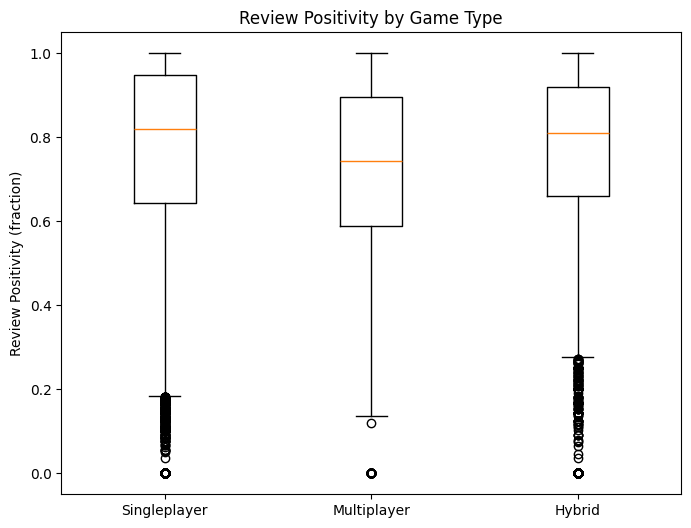

In [99]:
# Boxplot for review_score
plt.figure(figsize=(8,6))
data_for_box = [
    games.loc[games["game_type"]=="singleplayer", "review_score"].dropna(),
    games.loc[games["game_type"]=="multiplayer", "review_score"].dropna(),
    games.loc[games["game_type"]=="hybrid", "review_score"].dropna()
]
plt.boxplot(data_for_box, labels=["Singleplayer","Multiplayer","Hybrid"])
plt.title("Review Positivity by Game Type")
plt.ylabel("Review Positivity (fraction)")
plt.show()

In [100]:
# Kruskal-Wallis test (non-parametric alternative to ANOVA)
from scipy import stats
groups = [
    games.loc[games["game_type"]==t, "review_score"].dropna() 
    for t in ["singleplayer", "multiplayer", "hybrid"]
]
h_stat, p_value = stats.kruskal(*groups)
print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}, p-value: {p_value:.4e}")

Kruskal-Wallis H-statistic: 154.8829, p-value: 2.3313e-34


# Data Interpretation: Review Positivity

The **review positivity**, which is one of our metrics for game success, is **similar across all categories**.  
To get a better understanding of the success of each category, we need to consider **other metrics** such as estimated owners, log(owners), and the Success Index.

                 avg_owners  avg_log_owners  count
game_type                                         
singleplayer   23686.675593        7.654794  40329
multiplayer   391306.163575        8.535610   2372
hybrid        158117.423177        8.689369  10381


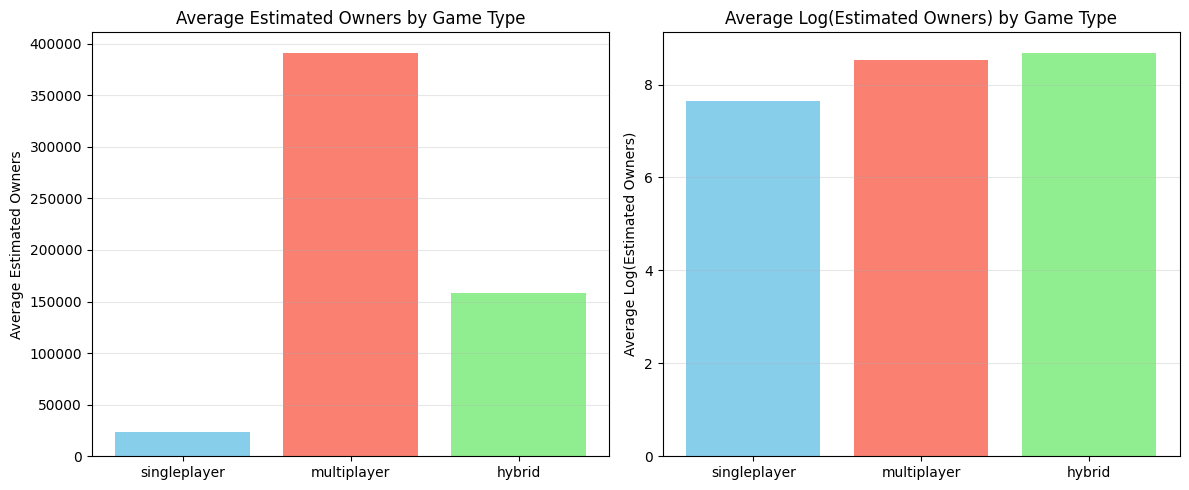

In [101]:
games["est_owners_est"] = pd.to_numeric(games["est_owners_est"], errors="coerce")

# Filter out missing or zero owners
games_valid = games.dropna(subset=["est_owners_est"])
games_valid = games_valid[games_valid["est_owners_est"] > 0]

# Compute log(owners)
games_valid["log_owners"] = np.log1p(games_valid["est_owners_est"])

# --- 2) Group by game type and compute averages ---
categories = ["singleplayer", "multiplayer", "hybrid"]
grouped_avg = games_valid.groupby("game_type").agg(
    avg_owners=("est_owners_est", "mean"),
    avg_log_owners=("log_owners", "mean"),
    count=("est_owners_est", "count")
).loc[categories]  # keep consistent order

print(grouped_avg)

# --- 3) Plot bar charts ---
plt.figure(figsize=(12,5))

# Average Estimated Owners
plt.subplot(1,2,1)
plt.bar(grouped_avg.index, grouped_avg["avg_owners"], color=['skyblue','salmon','lightgreen'])
plt.title("Average Estimated Owners by Game Type")
plt.ylabel("Average Estimated Owners")
plt.grid(True, axis='y', alpha=0.3)

# Average Log Owners
plt.subplot(1,2,2)
plt.bar(grouped_avg.index, grouped_avg["avg_log_owners"], color=['skyblue','salmon','lightgreen'])
plt.title("Average Log(Estimated Owners) by Game Type")
plt.ylabel("Average Log(Estimated Owners)")
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Estimated Owners Analysis by Game Type

| Game Type      | Avg Owners | Avg Log(Owners) | Count  |
|----------------|------------|----------------|--------|
| Singleplayer   | 23,686     | 7.65           | 40,329 |
| Multiplayer    | 391,306    | 8.54           | 2,372  |
| Hybrid         | 158,117    | 8.69           | 10,381 |

---

## Observations

- **Raw Average Owners** are skewed: Multiplayer appears highest due to few blockbuster hits.  
- **Log(Owners)** compresses extreme values, giving a more realistic comparison of typical game success:  
  - Singleplayer ~2k owners  
  - Multiplayer ~5k owners  
  - Hybrid ~6k owners

---

## Why Log Transformation

1. **Handles Skew:** Most games have few owners, a few have millions.  
2. **Compresses Large Values:** Reduces dominance of outliers.  
3. **Improves Success Index & Visualizations:** Ensures moderate games with high positivity still matter.

---

## Interpretation

- **Singleplayer:** Many games, generally lower owners → lower typical success.  
- **Multiplayer:** Few games, often blockbusters → raw average inflated, log gives realistic view.  
- **Hybrid:** Moderate count, consistent moderate-to-high owners → slightly higher typical success than multiplayer.

> **Key takeaway:** Log transformation makes owner comparisons **robust and fair across categories**, avoiding skew from extreme outliers.

In [102]:
summary = games.groupby("game_type").agg({
    "review_score": ["count", "mean", "median", "std"],
    "log_owners": ["mean", "median", "std"],
    "est_owners_est": ["mean", "median"],  # Add raw owners
    "metacritic_score": ["count", "mean", "median"],
    "success_index": ["count", "mean", "median", "std"]  # Add std
})
print("=== Summary by game_type ===")
print(summary)

=== Summary by game_type ===
             review_score                               log_owners            \
                    count      mean    median       std       mean    median   
game_type                                                                      
hybrid              13454  0.759098  0.809002  0.218272   8.689369  8.205492   
multiplayer          2584  0.715831  0.743117  0.232862   8.535610  7.901377   
other                1199  0.701935  0.750000  0.259633   8.289185  7.758333   
singleplayer        55326  0.755647  0.819537  0.245397   7.654794  7.230563   

                       est_owners_est         metacritic_score             \
                   std           mean  median            count       mean   
game_type                                                                   
hybrid        2.295629  110093.987121  1050.0             1282  74.166147   
multiplayer   2.397896  255053.643858   720.0               95  74.000000   
other         2.255426   

In [ ]:
# Get Top 5 Games by Success Index per Category

# Define the categories we want to look at
categories = ["singleplayer", "multiplayer", "hybrid"]

print("=== Top 10 Games by Success Index ===")

for category in categories:
    print(f"\n--- Top 10 {category.capitalize()} Games ---")
    
    # Filter by category, sort by success_index descending, take top 10
    top_games = games[games["game_type"] == category].nlargest(10, "success_index")
    
    # Print name and score
    for i, (index, row) in enumerate(top_games.iterrows(), 1):
        print(f"{i}. {row['name']} (Score: {row['success_index']:.2f})")

=== Top 10 Games by Success Index ===

--- Top 10 Singleplayer Games ---
1. Black Myth: Wukong (Score: 16.46)
2. The Witcher 3: Wild Hunt (Score: 16.27)
3. Hollow Knight (Score: 15.71)
4. People Playground (Score: 15.64)
5. Hades (Score: 15.58)
6. Undertale (Score: 15.22)
7. Geometry Dash (Score: 15.16)
8. RimWorld (Score: 15.15)
9. Doki Doki Literature Club! (Score: 15.10)
10. Slay the Spire (Score: 15.00)

--- Top 10 Multiplayer Games ---
1. Counter-Strike 2 (Score: 16.82)
2. Team Fortress 2 (Score: 15.53)
3. Among Us (Score: 15.37)
4. Rust (Score: 15.02)
5. Dota 2 (Score: 14.78)
6. It Takes Two (Score: 14.72)
7. Counter-Strike: Source (Score: 14.57)
8. SCP: Secret Laboratory (Score: 14.32)
9. Sea of Thieves: 2024 Edition (Score: 14.32)
10. Stick Fight: The Game (Score: 13.93)

--- Top 10 Hybrid Games ---
1. Terraria (Score: 16.88)
2. Garry's Mod (Score: 16.65)
3. Stardew Valley (Score: 16.64)
4. Euro Truck Simulator 2 (Score: 16.33)
5. Baldur's Gate 3 (Score: 16.25)
6. Phasmophobia 

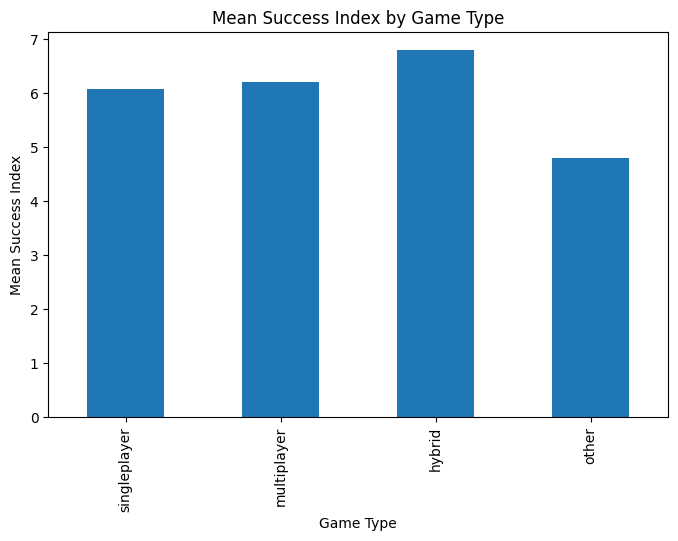

In [103]:
# ----------------------------
# 5. Success Index by Game Type
# ----------------------------
plt.figure(figsize=(8,5))
avg_success = games.groupby("game_type")["success_index"].mean().reindex(["singleplayer","multiplayer","hybrid","other"])
avg_success.plot(kind="bar")
plt.title("Mean Success Index by Game Type")
plt.xlabel("Game Type")
plt.ylabel("Mean Success Index")
plt.show()

# Data Interpretation: Success Index by Game Type

From the Success Index analysis:

- **Hybrid games** have the highest mean and median Success Index (mean ≈ 6.80, median ≈ 6.40), indicating they are typically the most successful across our metrics.
- **Singleplayer and Multiplayer games** have similar mean Success Index values (≈ 6.08 and 6.20, respectively), but medians are lower or zero, showing that many games in these categories have low or negligible success.
- The **'other' category** has a very low Success Index (mean ≈ 0.18), reflecting games outside the main types.

**Key Insights:**

1. **Hybrid games dominate success** because they combine elements of both singleplayer and multiplayer, attracting broader audiences and higher engagement.
2. **Singleplayer games** are numerous, but most have moderate owners or reviews, lowering the typical success score.
3. **Multiplayer games**, while including some blockbusters, are fewer in number, and the median Success Index of 0 indicates that many have low impact outside the most popular hits.
4. **Success Index** effectively captures both **review positivity** and **owner popularity**, showing that **category type influences typical game success** beyond just review scores.

> Overall, the analysis shows that hybrid games consistently outperform other categories in combined metrics of player satisfaction and reach.

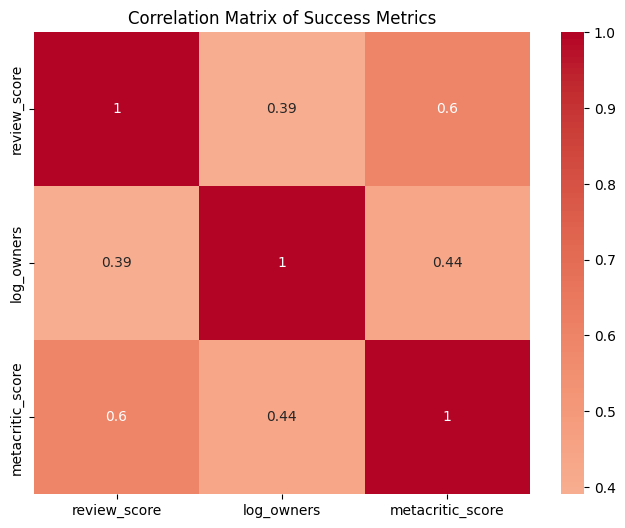

In [104]:
# Check correlation between metrics
metrics = games[["review_score", "log_owners", "metacritic_score"]].dropna()
correlation = metrics.corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Success Metrics")
plt.show()

In [105]:
# --- 1) Prepare groups ---
single = games[games["game_type"]=="singleplayer"]["success_index"].dropna()
multi  = games[games["game_type"]=="multiplayer"]["success_index"].dropna()
hybrid = games[games["game_type"]=="hybrid"]["success_index"].dropna()

groups = [single, multi, hybrid]
group_names = ["singleplayer", "multiplayer", "hybrid"]

# --- 2) Compute means ---
means = [g.mean() for g in groups]
n = [len(g) for g in groups]
overall_mean = np.mean(np.concatenate(groups))

# --- 3) Compute Sum of Squares Between (SSB) ---
SSB = sum([ni * (mi - overall_mean)**2 for ni, mi in zip(n, means)])

# --- 4) Compute Sum of Squares Within (SSW) ---
SSW = sum([sum((g - g.mean())**2) for g in groups])

# --- 5) Compute degrees of freedom ---
df_between = len(groups) - 1
df_within = sum(n) - len(groups)

# --- 6) Compute F-statistic ---
MSB = SSB / df_between
MSW = SSW / df_within
F_stat = MSB / MSW

# --- 7) Print results ---
print("=== ANOVA RESULTS ===")
print("F-statistic:", F_stat)
print("df_between:", df_between, ", df_within:", df_within)

=== ANOVA RESULTS ===
F-statistic: 394.66821966059456
df_between: 2 , df_within: 43985


# One-Way ANOVA: Success Index by Game Type

## Hypotheses

- **Null Hypothesis (H0):** The mean Success Index is the same across all game types (singleplayer, multiplayer, hybrid).  
- **Alternative Hypothesis (H1):** At least one game type has a different mean Success Index.

---

## ANOVA Results

- **F-statistic:** 394.67
- **Degrees of Freedom:** df_between = 2, df_within = 43985 

**Interpretation:**

- The **very high F-statistic** indicates that the differences in mean Success Index between game types are much larger than the variability within each category.  
- This provides **strong evidence to reject the null hypothesis (H0)**.  
- Conclusion: At least one game type differs significantly in typical Success Index.

> In our dataset, hybrid games have the highest mean and median Success Index, confirming the ANOVA result that game type affects success.